<img src = "https://drive.google.com/uc?export=view&id=1FNyRcLn_ZqLm263UvW1gEDW1_QaTr9hG" alt = "Encabezado MLDS" width = "100%">  </img>

In [1]:
# @title Instalar dependencias

!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.4 MB/s eta 0:00:00


In [2]:
# @title Importar paquetes

import numpy as np
import keras
from tensorflow.keras.datasets import mnist 
from skimage.filters import rank
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.keras import backend as K
import keras_tuner as kt

# **Entrenamiento y Validación**
---

Este notebook es una plantilla que le puede servir como guía para el cuarto entregable del proyecto aplicado.

## **1. Entrenamiento del Modelo y Selección de Hiperparámetros**
---

Si está utilizando un modelo que requiere entrenamiento, deberá entrenarlo y seleccionar un conjunto de hiperparámetros válido para el mismo. Recuerde que tiene diversas erramientas para hacer validación.

In [3]:
# @title Espacio de hiperparámetros

filter_number = [1,7] #Variable de rango
filter_size = [3,5,7]#Variable de selección
emb_size = [16, 256]#Variable de rango
pooling_size = [2,3]#Variable de selección

In [4]:
# @title Generador de modelos

def build_model(hp):

  filter_number_parameter = hp.Int("Filter number", min_value=np.min(filter_number), max_value=np.max(filter_number), step=1) 
  filter_size_parameter = hp.Choice('Filter size', filter_size)
  emb_size_parameter = hp.Int("Embedding size", min_value=np.min(emb_size), max_value=np.max(emb_size), step=16)
  pooling_size_parameter = hp.Choice('Pooling size', pooling_size)


  cnn = Sequential()
  cnn.add(Convolution2D(filter_number_parameter, (filter_size_parameter, filter_size_parameter), padding ="same", input_shape=(50, 50,1), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(pooling_size_parameter, pooling_size_parameter)))

  cnn.add(Convolution2D(filter_number_parameter, (filter_size_parameter, filter_size_parameter), padding ="same"))
  cnn.add(MaxPooling2D(pool_size=(pooling_size_parameter, pooling_size_parameter)))

  cnn.add(Flatten())
  cnn.add(Dense(emb_size_parameter, activation='relu'))
  cnn.add(Dense(10, activation='softmax'))

  cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

  return cnn

cnn = build_model(kt.HyperParameters())
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 1)         10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 1)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 1)         10        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 1)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 16)                2

In [5]:
# @title Generador de datos

class DataGenerator(keras.utils.Sequence):

    #Generates data for Keras
      #train(bool): vamos a tomar el conjunto de entranmiento o validación?.
      #blur_rate(float): rate of bluring filter.
      #noise_rate(float): signal to noise ratio.
      #augmentation_rate(float): probabilitie of augmentation
      #batch_size(int): tamaño del conjunto por paso.
      #dim(array): tamaño final de la imagen.
      #shuffle(bool): variación aleatoria de los conjuntos por paso?.
    def __init__(self, train, blur_rate=0.1, noise_rate = 0.1, augmentation_rate=0.5, batch_size=32, dim=(32,32), shuffle=True):
      # Intialize values *
      self.train = train
      self.blur_rate = blur_rate
      self.noise_rate = noise_rate
      self.augmentation_rate = augmentation_rate
      self.batch_size = batch_size
      self.dim = dim
      self.shuffle = shuffle

      self.load_data()
      self.on_epoch_end()

    def load_data(self):
      #Load dataset
      (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

      if self.train == True:
        self.X = x_train
        self.Y = y_train
      else:
        self.X = x_test
        self.Y = y_test

    def add_noise(self, im):
      #Add noise
      noise_mag = np.max(im) * self.noise_rate
      noise_im = im + (noise_mag * np.random.rand(im.shape[0],im.shape[1]))
      return noise_im

    def add_blur(self, im):
      #Add blur
      filter_size = [int(im.shape[0]*self.noise_rate), int(im.shape[1]*self.noise_rate)]
      blur_im = rank.mean(im, footprint=np.ones(filter_size))
      return blur_im

    def normalize_image(self,im):
      im = (im - np.min(im))/(np.max(im) - np.min(im))
      return(im)

    def __len__(self):
        #Denotes the number of batches per epoch*
        return int(np.floor(len(self.Y) / self.batch_size))

    def __getitem__(self, index):
        #Generate one batch of data*

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        #Updates indexes after each epoch*
        self.indexes = np.arange(len(self.Y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
      #Generates data containing batch_size samples*
      # Initialization
      X = []
      Y = []

      # Generate data
      for index in indexes:
        im = self.X[index]
        y = self.Y[index]

        transform = np.random.rand() < self.augmentation_rate
        
        if transform == False:
          im = resize(im, self.dim, anti_aliasing=True)
          im = self.normalize_image(im)
        else:
          im = resize(im, self.dim, anti_aliasing=True)
          #im = self.add_blur(im)
          im = self.add_noise(im)
          im = self.normalize_image(im)
        
        X.append(im)
        Y.append(y)

      X = np.array(X)
      Y = np.array(Y)
      Y =  keras.utils.to_categorical(Y, num_classes=10)
      return (X,Y)


In [6]:
training_generator = DataGenerator(True, blur_rate=0.1, noise_rate = 0.25, augmentation_rate=0.5, batch_size=32, dim=(50,50), shuffle=True)
test_generator = DataGenerator(False, blur_rate=0.1, noise_rate = 0.25, augmentation_rate=0, batch_size=1000, dim=(50,50), shuffle=True)

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
# @title Busqueda de hiperparametros

# Modelo de busqueda 

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="",
    project_name="mnist",
)

# Busqueda
tuner.search(training_generator, epochs=5, validation_data=(test_generator))

Trial 10 Complete [00h 06m 20s]
val_accuracy: 0.9837499856948853

Best val_accuracy So Far: 0.9887000024318695
Total elapsed time: 01h 04m 06s


In [9]:
tuner.results_summary()

Results summary
Results in ./mnist
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
Filter number: 7
Filter size: 7
Embedding size: 176
Pooling size: 2
Score: 0.9887000024318695

Trial 03 summary
Hyperparameters:
Filter number: 7
Filter size: 7
Embedding size: 240
Pooling size: 2
Score: 0.988649994134903

Trial 06 summary
Hyperparameters:
Filter number: 6
Filter size: 7
Embedding size: 224
Pooling size: 3
Score: 0.9885999858379364

Trial 01 summary
Hyperparameters:
Filter number: 4
Filter size: 7
Embedding size: 224
Pooling size: 2
Score: 0.9884500205516815

Trial 04 summary
Hyperparameters:
Filter number: 5
Filter size: 7
Embedding size: 208
Pooling size: 3
Score: 0.9882000088691711

Trial 02 summary
Hyperparameters:
Filter number: 2
Filter size: 7
Embedding size: 208
Pooling size: 2
Score: 0.9846000075340271

Trial 09 summary
Hyperparameters:
Filter number: 5
Filter size: 3
Embedding size: 80
Pooling size: 2
Score: 0.9837499856

## **2. Evaluación o Aplicación del modelo**
---

Si entrenó un modelo, recuerde que debe reportar el desempeño del mismo sobre un conjunto de datos no visto (test). Considere que dispone de las siguientes métricas:

- **Clasificación**: accuracy, precision, recall, f1-score, AUC.
- **Regresión**: $r^2$, error cuadrático medio, error absoluto medio.
- **Agrupamiento**: coeficiente de silueta, índice de Davies-Bouldin.

In [16]:
best_hps = tuner.get_best_hyperparameters(1)[0]

cnn = build_model(best_hps)
cnn.fit(training_generator, epochs=5, validation_data=(test_generator))

Epoch 1/5
1875/1875 [==============================] - 39s 20ms/step - loss: 0.1469 - accuracy: 0.9553 - val_loss: 0.0689 - val_accuracy: 0.9767
Epoch 2/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0512 - accuracy: 0.9844 - val_loss: 0.0436 - val_accuracy: 0.9862
Epoch 3/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0363 - accuracy: 0.9884 - val_loss: 0.0536 - val_accuracy: 0.9836
Epoch 4/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 0.0566 - val_accuracy: 0.9831
Epoch 5/5
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0225 - accuracy: 0.9929 - val_loss: 0.0516 - val_accuracy: 0.9870


Adicionalmente, si utilizó un modelo pre-entrenado, debe generar predicciones y mostrar el resultado final de la aplicación del modelo sobre sus datos:

32/32 [==============================] - 0s 2ms/step
[0 0 0 0 0 0 0 1 0 0]


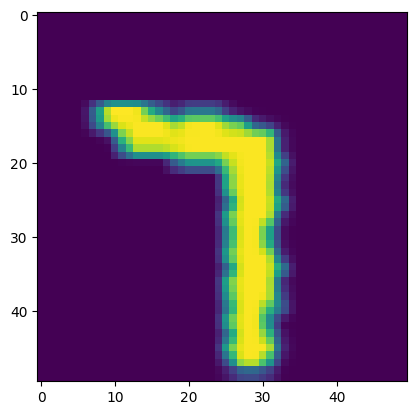

[0 1 0 0 0 0 0 0 0 0]


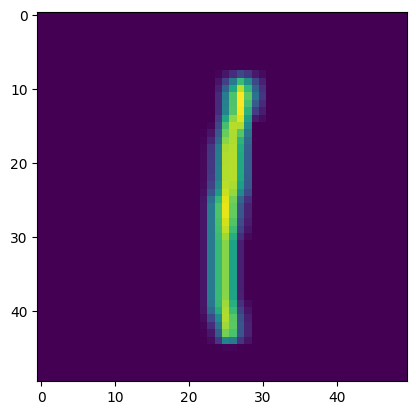

[0 0 0 0 1 0 0 0 0 0]


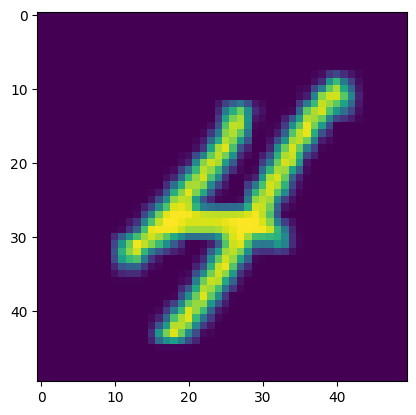

[0 0 1 0 0 0 0 0 0 0]


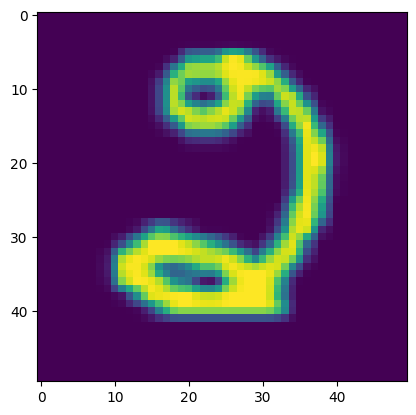

[1 0 0 0 0 0 0 0 0 0]


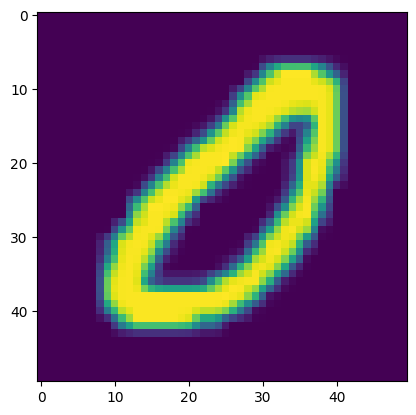

In [25]:
x,y = test_generator.__getitem__(0)
y_pred = cnn.predict(x)

for i in range (5):
  v = np.random.randint(0, high=32)
  
  image = x[v]
  pred = y_pred[v]

  print(1*(pred==np.max(pred)))
  plt.imshow(image)
  plt.show()

# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/) 
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*